In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from optical_bloch.utils.general import flatten
from optical_bloch.utils.setup import hamiltonian_setup
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

plt.rcParams.update({"font.size": 14})

In [2]:
ham = hamiltonian_setup(5, [(0, 4), (1, 4), (2, 4), (3, 4)])
ham.transformed

Matrix([
[             -δ0,                0,                0,                0, -Ω0/2],
[               0,              -δ1,                0,                0, -Ω1/2],
[               0,                0,              -δ2,                0, -Ω2/2],
[               0,                0,                0,              -δ3, -Ω3/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2, -conjugate(Ω2)/2, -conjugate(Ω3)/2,     0]])

## Test

In [3]:
energies = smp.symbols("E0:4", real=True)

omegas = smp.symbols("ω0:2", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:2", real=True)
Gammas = smp.symbols("Γ0:2", real=True)

In [4]:
ham = Hamiltonian(4)
ham.add_energies(energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(0, 3, Omegas[0], omegas[0])
ham.add_coupling(1, 2, Omegas[1], omegas[1])
ham.add_coupling(1, 3, Omegas[1], omegas[1])

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(1, 2, deltas[1])

display(ham.transformed)

ham.remove_common_energy()

transformed = ham.transformed

transformed

Matrix([
[                               E0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2, -Ω0*exp(1.0*I*t*ω0)/2],
[                                0,                                E1, -Ω1*exp(1.0*I*t*ω1)/2, -Ω1*exp(1.0*I*t*ω1)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2,                    E2,                     0],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2,                     0,                    E3]])

Matrix([
[         E0 + ω0,                0, -Ω0/2, -Ω0/2],
[               0,          E1 + ω1, -Ω1/2, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2,     0],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0,    E3]])

Matrix([
[         E2 - δ0,                0, -Ω0/2, -Ω0/2],
[               0,          E2 - δ1, -Ω1/2, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2,     0],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0,    E3]])

Matrix([
[             -δ0,                0, -Ω0/2,    -Ω0/2],
[               0,              -δ1, -Ω1/2,    -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0,        0],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0, -E2 + E3]])

# Toy Λ system

In [5]:
energies = smp.symbols("E0:3", real=True)

omegas = smp.symbols("ω0:2", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:2", real=True)
Gammas = smp.symbols("Γ0:2", real=True)

In [6]:
ham = Hamiltonian(3)
ham.add_energies(energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(1, 2, Omegas[1], omegas[1])

display(ham.hamiltonian)

ham.eqn_transform()

display(ham.transformed)

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(1, 2, deltas[1])

display(ham.transformed)

ham.remove_common_energy()

transformed = ham.transformed

transformed

Matrix([
[                               E0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2],
[                                0,                                E1, -Ω1*exp(1.0*I*t*ω1)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω1)/2,                    E2]])

Matrix([
[         E0 + ω0,                0, -Ω0/2],
[               0,          E1 + ω1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2]])

Matrix([
[         E2 - δ0,                0, -Ω0/2],
[               0,          E2 - δ1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,    E2]])

Matrix([
[             -δ0,                0, -Ω0/2],
[               0,              -δ1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0]])

In [7]:
dis = Dissipator(ham.levels)

for idi, idf, Gamma in zip([2, 2], [0, 1], Gammas):
    dis.add_decay(idi, idf, Gamma)

bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [8]:
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(bloch.equations.rhs, bloch.density_matrix, [])
)

In [9]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		Ω0 = p[3]
		Ω1 = p[4]
		δ0 = p[5]
		δ1 = p[6]
		du[1,1] = Γ0*u[3,3] + 1.0im*(Ω0*conj(u[1,3]) - u[1,3]*conj(Ω0))/2
		du[1,2] = 1.0im*(Ω0*conj(u[2,3])/2 + δ0*u[1,2] - δ1*u[1,2] - u[1,3]*conj(Ω1)/2)
		du[1,3] = -(Γ0 + Γ1)*u[1,3]/2 - 1.0im*(Ω0*u[1,1] - Ω0*u[3,3] + Ω1*u[1,2] - 2*δ0*u[1,3])/2
		du[2,2] = Γ1*u[3,3] + 1.0im*(Ω1*conj(u[2,3]) - u[2,3]*conj(Ω1))/2
		du[2,3] = -(Γ0 + Γ1)*u[2,3]/2 - 1.0im*(Ω0*conj(u[1,2]) + Ω1*u[2,2] - Ω1*u[3,3] - 2*δ1*u[2,3])/2
		du[3,3] = -(Γ0 + Γ1)*u[3,3] - 1.0im*(Ω0*conj(u[1,3]) + Ω1*conj(u[2,3]) - u[1,3]*conj(Ω0) - u[2,3]*conj(Ω1))/2
	end
	nothing
end


In [10]:
smp.nsimplify(bloch.equations.rhs[0, 1])

I*(Ω0*conjugate(ρ₁₂(t))/2 + δ0*ρ₀₁(t) - δ1*ρ₀₁(t) - ρ₀₂(t)*conjugate(Ω1)/2)

In [11]:
%%time
steady_state = bloch.solve_steady_state_symbolic(
    replacements=[
        (Gammas[0], 1 / 2),
        (Gammas[1], 1 / 2),
        (deltas[0], 0),
        (deltas[1], 0),
    ]
)

CPU times: total: 344 ms
Wall time: 751 ms


In [12]:
smp.nsimplify(smp.simplify(steady_state[list(steady_state.keys())[0]].subs([])))

Ω1*conjugate(Ω1)/(Ω0*conjugate(Ω0) + Ω1*conjugate(Ω1))

In [13]:
replacements = [
    (Gammas[0], 1 / 2),
    (Gammas[1], 1 / 2),
    (deltas[0], 0),
    (deltas[1], 0),
    (
        Omegas[0],
        0.5 * ((1 + smp.cos(2 * 3.1415 * 0 * smp.Symbol("t", real=True))) / 2),
    ),
    (Omegas[1], 1),
]

y0 = np.zeros(bloch.levels**2, dtype=complex)
y0[0] = 1 / 2
y0[4] = 1 / 2

In [14]:
from scipy.integrate import solve_ivp

tspan = (0, 50)
method = "RK45"
matrix_eq, t_dependent = bloch.generate_system(replacements)

# ODE solver
if t_dependent:

    def fun(t, rho):
        return matrix_eq(t) @ rho
else:

    def fun(t, rho):
        return matrix_eq @ rho


sol = solve_ivp(fun, tspan, y0, method, vectorized=True, max_step=0.1)

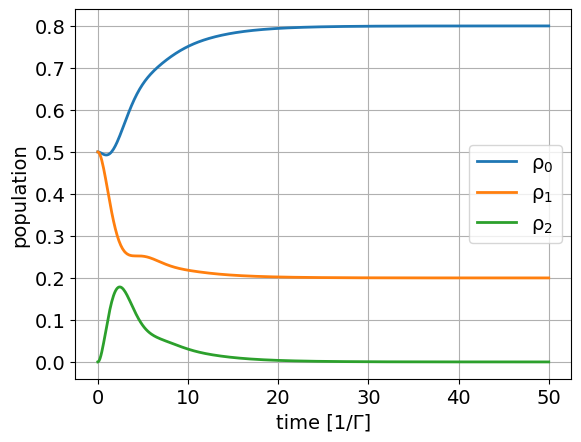

In [15]:
y = sol.y.reshape(bloch.levels, bloch.levels, -1)

fig, ax = plt.subplots()

for idx in range(3):
    ax.plot(sol.t, y[idx, idx].real, lw=2, label=f"ρ$_{idx}$")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")

ax.legend()

ax.grid()

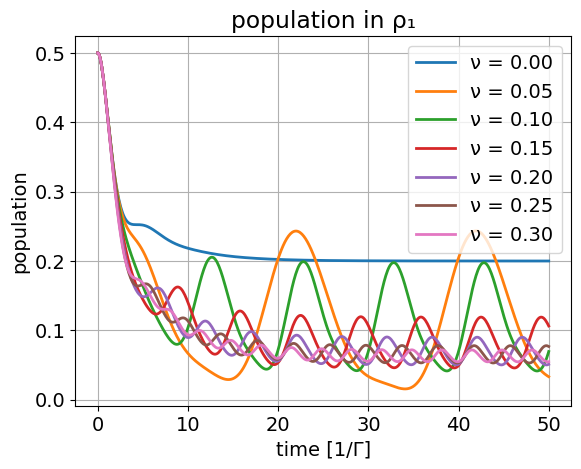

In [16]:
fig, ax = plt.subplots()
for v in np.arange(0, 0.31, 0.05):
    replacements = [
        (Gammas[0], 1 / 2),
        (Gammas[1], 1 / 2),
        (deltas[0], 0),
        (deltas[1], 0),
        (
            Omegas[0],
            0.5 * ((1 + smp.cos(2 * 3.1415 * v * smp.Symbol("t", real=True))) / 2),
        ),
        (Omegas[1], 1),
    ]
    tspan = (0, 50)
    method = "RK45"
    matrix_eq, t_dependent = bloch.generate_system(replacements)

    # ODE solver
    if t_dependent:

        def fun(t, rho):
            return matrix_eq(t) @ rho
    else:

        def fun(t, rho):
            return matrix_eq @ rho

    sol = solve_ivp(fun, tspan, y0, method, vectorized=True, max_step=0.1)

    y = sol.y.reshape(bloch.levels, bloch.levels, -1)

    ax.plot(sol.t, y[1, 1].real, lw=2, label=f"ν = {v:.2f}")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")
ax.set_title("population in ρ₁")

ax.legend()

ax.grid()

In [17]:
%%timeit
sol = solve_ivp(fun, tspan, y0, method="RK45", vectorized=True)

18.3 ms ± 884 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
dis.dissipator

Matrix([
[                     Γ0*ρ₂₂(t),                              0, (-Γ0 - Γ1)*ρ₀₂(t)/2],
[                             0,                      Γ1*ρ₂₂(t), (-Γ0 - Γ1)*ρ₁₂(t)/2],
[(-Γ0 - Γ1)*conjugate(ρ₀₂(t))/2, (-Γ0 - Γ1)*conjugate(ρ₁₂(t))/2,   (-Γ0 - Γ1)*ρ₂₂(t)]])

In [19]:
bloch.equations.rhs

Matrix([
[                                                                                            Γ0*ρ₂₂(t) + 0.5*I*(Ω0*conjugate(ρ₀₂(t)) - ρ₀₂(t)*conjugate(Ω0)),                                                          I*(0.5*Ω0*conjugate(ρ₁₂(t)) + 1.0*δ0*ρ₀₁(t) - 1.0*δ1*ρ₀₁(t) - 0.5*ρ₀₂(t)*conjugate(Ω1)),                             -(Γ0 + Γ1)*ρ₀₂(t)/2 - I*(1.0*Ω0*ρ₀₀(t) - 1.0*Ω0*ρ₂₂(t) + 1.0*Ω1*ρ₀₁(t) - 2.0*δ0*ρ₀₂(t))/2],
[                                              I*(0.5*Ω1*conjugate(ρ₀₂(t)) - 1.0*δ0*conjugate(ρ₀₁(t)) + 1.0*δ1*conjugate(ρ₀₁(t)) - 0.5*ρ₁₂(t)*conjugate(Ω0)),                                                                                  Γ1*ρ₂₂(t) + 0.5*I*(Ω1*conjugate(ρ₁₂(t)) - ρ₁₂(t)*conjugate(Ω1)),                  -(Γ0 + Γ1)*ρ₁₂(t)/2 - I*(1.0*Ω0*conjugate(ρ₀₁(t)) + 1.0*Ω1*ρ₁₁(t) - 1.0*Ω1*ρ₂₂(t) - 2.0*δ1*ρ₁₂(t))/2],
[-(Γ0 + Γ1)*conjugate(ρ₀₂(t))/2 - I*(2.0*δ0*conjugate(ρ₀₂(t)) - 1.0*ρ₀₀(t)*conjugate(Ω0) + 1.0*ρ₂₂(t)*conjugate(Ω0) - 1.0*conjugate(Ω1)*conjuga

# Toy 4 Level Model

In [20]:
ρ = smp.MatrixSymbol("ρ", 4, 4)

energies = smp.symbols("E0:4", real=True)

omegas = smp.symbols("ω0:1", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:1", real=True)
Gammas = smp.symbols("Γ0:4", real=True)

In [21]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham.add_manifold_coupling([0, 1], [2, 3], Omegas, omegas[0])
ham.eqn_transform()
display(ham.hamiltonian)
display(ham.transformed)
ham.define_state_detuning(1, 3, deltas[0])
display(ham.transformed)
ham.remove_common_energy()
display(ham.transformed)

Matrix([
[                               E0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2,                     0],
[                                0,                                E1,                     0, -Ω1*exp(1.0*I*t*ω0)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2,                                 0,                    E2,                     0],
[                                0, -exp(-1.0*I*t*ω0)*conjugate(Ω1)/2,                     0,                    E3]])

Matrix([
[         E0 + ω0,                0, -Ω0/2,     0],
[               0,          E1 + ω0,     0, -Ω1/2],
[-conjugate(Ω0)/2,                0,    E2,     0],
[               0, -conjugate(Ω1)/2,     0,    E3]])

Matrix([
[E0 - E1 + E3 - δ0,                0, -Ω0/2,     0],
[                0,          E3 - δ0,     0, -Ω1/2],
[ -conjugate(Ω0)/2,                0,    E2,     0],
[                0, -conjugate(Ω1)/2,     0,    E3]])

Matrix([
[    E0 - E1 - δ0,                0,   -Ω0/2,     0],
[               0,              -δ0,       0, -Ω1/2],
[-conjugate(Ω0)/2,                0, E2 - E3,     0],
[               0, -conjugate(Ω1)/2,       0,     0]])

In [22]:
ham.transformed = ham.transformed.subs(
    energies[0] - energies[1], smp.Symbol("-Δg", real=True)
)
ham.transformed = ham.transformed.subs(
    energies[2] - energies[3], smp.Symbol("-Δe", real=True)
)
ham.transformed

Matrix([
[        -Δg - δ0,                0, -Ω0/2,     0],
[               0,              -δ0,     0, -Ω1/2],
[-conjugate(Ω0)/2,                0,   -Δe,     0],
[               0, -conjugate(Ω1)/2,     0,     0]])

In [23]:
def symbolic_matrix_to_julia(matrix) -> str:
    s = matrix.shape
    matrix_str = "[\n"
    for idx in range(s[0]):
        for idy in range(s[1]):
            matrix_str += f"{str(matrix[idx,idy])} "
        matrix_str += "\n"
    matrix_str += "]"
    matrix_str = matrix_str.replace("conjugate", "conj")
    return matrix_str

In [24]:
def get_symbols_to_julia(matrix) -> str:
    return (
        f"@parameters {str(matrix.free_symbols)}".replace(",", "")
        .replace("{", "")
        .replace("}", "")
        .replace("-", "")
    )

In [25]:
print(get_symbols_to_julia(ham.transformed))

@parameters Ω0 δ0 Ω1 Δg Δe


In [26]:
print(symbolic_matrix_to_julia(ham.transformed))

[
-Δg - δ0 0 -Ω0/2 0 
0 -δ0 0 -Ω1/2 
-conj(Ω0)/2 0 -Δe 0 
0 -conj(Ω1)/2 0 0 
]


In [27]:
dis = Dissipator(ham.levels)

for idi, idf, Gamma in zip([2, 2, 3, 3], [0, 1, 0, 1], Gammas):
    dis.add_decay(idi, idf, Gamma)

In [28]:
bloch = BlochEquations(ham.levels, dis.density_matrix, ham.transformed, dis.dissipator)

# Toy 4 Level system with 1 excited states

In [29]:
energies = smp.symbols("E0:4", real=True)

omegas = smp.symbols("ω0:3", real=True)
Omegas = smp.symbols("Ω0:3", complex=True)
deltas = smp.symbols("δ0:3", real=True)
Gammas = smp.symbols("Γ0:2", real=True)

In [30]:
ham = Hamiltonian(energies=energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(0, 3, Omegas[1], omegas[1])
ham.add_coupling(1, 2, Omegas[2], omegas[2])
ham.eqn_transform()

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(0, 3, deltas[1])
ham.define_state_detuning(1, 2, deltas[2])

In [31]:
ham.transformed

Matrix([
[         E3 - δ1,                 0,        -Ω0/2, -Ω1/2],
[               0, E3 + δ0 - δ1 - δ2,        -Ω2/2,     0],
[-conjugate(Ω0)/2,  -conjugate(Ω2)/2, E3 + δ0 - δ1,     0],
[-conjugate(Ω1)/2,                 0,            0,    E3]])

# Toy Rotational Cooling

In [32]:
ρ = smp.MatrixSymbol("ρ", 5, 5)

energies = smp.symbols("E0:5", real=True)

omegas = smp.symbols("ω0:3", real=True)
Omegas = smp.symbols("Ω0:3", complex=True)
deltas = smp.symbols("δ0:3", real=True)
Gammas = smp.symbols("Γ0:2", real=True)

In [33]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham.add_coupling(1, 2, Omegas[0], omegas[0])
ham.add_coupling(2, 3, Omegas[1], omegas[1])
ham.add_coupling(2, 4, Omegas[2], omegas[2])

In [34]:
ham.eqn_transform()
ham.transformed

Matrix([
[E0,                0,                0,            0,     0],
[ 0,     E1 + ω0 + ω2,            -Ω0/2,            0,     0],
[ 0, -conjugate(Ω0)/2,          E2 + ω2,        -Ω1/2, -Ω2/2],
[ 0,                0, -conjugate(Ω1)/2, E3 - ω1 + ω2,     0],
[ 0,                0, -conjugate(Ω2)/2,            0,    E4]])

In [35]:
ham.define_state_detuning(1, 2, deltas[0])
ham.define_state_detuning(2, 3, deltas[1])
ham.define_state_detuning(2, 4, deltas[2])
display(ham.transformed)
ham.remove_common_energy()
display(ham.transformed)

Matrix([
[E0,                0,                0,            0,     0],
[ 0,     E4 - δ0 - δ2,            -Ω0/2,            0,     0],
[ 0, -conjugate(Ω0)/2,          E4 - δ2,        -Ω1/2, -Ω2/2],
[ 0,                0, -conjugate(Ω1)/2, E4 + δ1 - δ2,     0],
[ 0,                0, -conjugate(Ω2)/2,            0,    E4]])

Matrix([
[E0 - E4,                0,                0,       0,     0],
[      0,         -δ0 - δ2,            -Ω0/2,       0,     0],
[      0, -conjugate(Ω0)/2,              -δ2,   -Ω1/2, -Ω2/2],
[      0,                0, -conjugate(Ω1)/2, δ1 - δ2,     0],
[      0,                0, -conjugate(Ω2)/2,       0,     0]])

In [36]:
dis = Dissipator(ham.levels)
dis.add_decay(4, 2, Gammas[0])
dis.add_decay(4, 0, Gammas[1])

transformed = ham.transformed.copy()

In [37]:
transformed = transformed.subs(energies[0], 0)
transformed = smp.nsimplify(transformed.subs(energies[-1], 0))
transformed

Matrix([
[0,                0,                0,       0,     0],
[0,         -δ0 - δ2,            -Ω0/2,       0,     0],
[0, -conjugate(Ω0)/2,              -δ2,   -Ω1/2, -Ω2/2],
[0,                0, -conjugate(Ω1)/2, δ1 - δ2,     0],
[0,                0, -conjugate(Ω2)/2,       0,     0]])

In [38]:
bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [39]:
t = smp.Symbol("t", real=True)

replacements = [(delta, 0) for delta in deltas]
# replacements += [(Omega, 1) for Omega in Omegas]
replacements += [(Gamma, 1 / 2) for Gamma in Gammas]
replacements += [
    (Omegas[0], 1 * (1 + smp.sin(smp.Symbol("ωl") * t) / 2)),
    (Omegas[1], 1 * (1 + smp.sin(smp.Symbol("ωl") * t + 3.1415 / 2) / 2)),
    (Omegas[2], 1 * (1 + smp.sin(smp.Symbol("ωl") * t + 3.1415 / 4) / 2)),
]

In [40]:
y0 = np.zeros(bloch.levels**2, dtype=complex)
y0[0] = 1 / 4
y0[6] = 1 / 4
y0[12] = 1 / 4
y0[18] = 1 / 4

In [41]:
sol = bloch.solve_numeric(
    replacements + [(smp.Symbol("ωl"), 1)], [0, 100], y0, method="BDF"
)

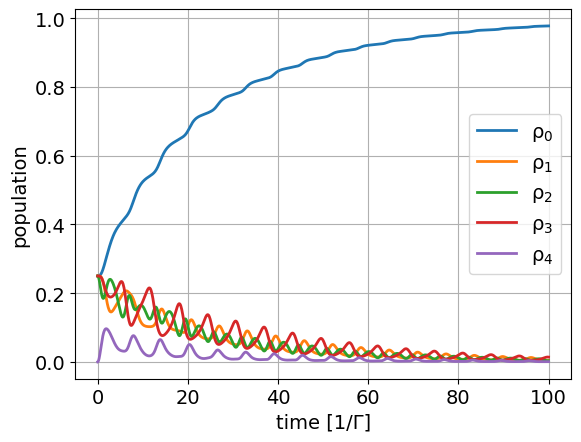

In [42]:
y = sol.y.reshape(5, 5, -1)

fig, ax = plt.subplots()

for idx in range(5):
    ax.plot(sol.t, y[idx, idx].real, lw=2, label=f"ρ$_{idx}$")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")

ax.legend()

ax.grid()

In [43]:
replacements = [(delta, 0) for delta in deltas]
# replacements += [(Omega, 1) for Omega in Omegas]
replacements += [(Gamma, 1 / 2) for Gamma in Gammas]
replacements += [
    (Omegas[0], 1 * (1 + smp.sin(smp.Symbol("ωl") * t) / 2)),
    (Omegas[1], 1 * (1 + smp.sin(smp.Symbol("ωl") * t + 3.1415 / 2) / 2)),
    (Omegas[2], 1 * (1 + smp.sin(smp.Symbol("ωl") * t + 3.1415 / 4) / 2)),
]
replacements += [(smp.Symbol("ωl"), 1 + smp.sin(smp.Symbol("ωl1") * t) / 5)]

In [44]:
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements
    )
)

In [45]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		ωl1 = p[1]
		δ0 = 0
		δ1 = 0
		δ2 = 0
		Γ0 = 0.5
		Γ1 = 0.5
		ωl = sin(t*ωl1)/5 + 1
		Ω0 = sin(t*ωl)/2 + 1
		Ω1 = sin(t*ωl + 1.57075)/2 + 1
		Ω2 = sin(t*ωl + 0.785375)/2 + 1
		du[1,1] = Γ1*u[5,5]
		du[1,2] = 1.0im*(-(δ0 + δ2)*u[1,2] - u[1,3]*conj(Ω0)/2)
		du[1,3] = 1.0im*(-Ω0*u[1,2]/2 - δ2*u[1,3] - u[1,4]*conj(Ω1)/2 - u[1,5]*conj(Ω2)/2)
		du[1,4] = 1.0im*(-Ω1*u[1,3]/2 + (δ1 - δ2)*u[1,4])
		du[1,5] = -1.0im*Ω2*u[1,3]/2 - (Γ0 + Γ1)*u[1,5]/2
		du[2,2] = 1.0im*(Ω0*conj(u[2,3]) - u[2,3]*conj(Ω0))/2
		du[2,3] = 1.0im*(-Ω0*u[2,2]/2 + Ω0*u[3,3]/2 + δ0*u[2,3] - u[2,4]*conj(Ω1)/2 - u[2,5]*conj(Ω2)/2)
		du[2,4] = 1.0im*(Ω0*u[3,4]/2 - Ω1*u[2,3]/2 + δ0*u[2,4] + δ1*u[2,4])
		du[2,5] = -(Γ0 + Γ1)*u[2,5]/2 + 1.0im*(Ω0*u[3,5] - Ω2*u[2,3] + 2*(δ0 + δ2)*u[2,5])/2
		du[3,3] = Γ0*u[5,5] + 1.0im*(-Ω0*conj(u[2,3]) + Ω1*conj(u[3,4]) + Ω2*conj(u[3,5]) + u[2,3]*conj(Ω0) - u[3,4]*conj(Ω1) - u[3,5]*conj(Ω2))/2
		du[3,4] = 1.0im*(-Ω1*u[3,3]/2 + Ω1*u[4,4]/2

# Toy Rotational Cooling Polarization Switching 

In [46]:
ρ = smp.MatrixSymbol("ρ", 6, 6)

energies = smp.symbols("E0:6", real=True)

omegas = smp.symbols("ω0:4", real=True)
Omegas = smp.symbols("Ω0:4", complex=True)
deltas = smp.symbols("δ0:4", real=True)
Gammas = smp.symbols("Γ0:4", real=True)

In [47]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham.add_coupling(1, 2, Omegas[0], omegas[0])
ham.add_coupling(2, 3, Omegas[1], omegas[1])
ham.add_coupling(2, 4, Omegas[2], omegas[2])
ham.add_coupling(2, 5, Omegas[3], omegas[3])

In [48]:
ham.eqn_transform()
ham.transformed

Matrix([
[E0,                0,                0,            0,            0,     0],
[ 0,     E1 + ω0 + ω3,            -Ω0/2,            0,            0,     0],
[ 0, -conjugate(Ω0)/2,          E2 + ω3,        -Ω1/2,        -Ω2/2, -Ω3/2],
[ 0,                0, -conjugate(Ω1)/2, E3 - ω1 + ω3,            0,     0],
[ 0,                0, -conjugate(Ω2)/2,            0, E4 - ω2 + ω3,     0],
[ 0,                0, -conjugate(Ω3)/2,            0,            0,    E5]])

In [49]:
ham.define_state_detuning(1, 2, deltas[0])
ham.define_state_detuning(2, 3, deltas[1])
ham.define_state_detuning(2, 4, deltas[2])
ham.define_state_detuning(2, 5, deltas[3])
display(ham.transformed)
ham.remove_common_energy()
ham.transformed

Matrix([
[E0,                0,                0,            0,            0,     0],
[ 0,     E5 - δ0 - δ3,            -Ω0/2,            0,            0,     0],
[ 0, -conjugate(Ω0)/2,          E5 - δ3,        -Ω1/2,        -Ω2/2, -Ω3/2],
[ 0,                0, -conjugate(Ω1)/2, E5 + δ1 - δ3,            0,     0],
[ 0,                0, -conjugate(Ω2)/2,            0, E5 + δ2 - δ3,     0],
[ 0,                0, -conjugate(Ω3)/2,            0,            0,    E5]])

Matrix([
[E0 - E5,                0,                0,       0,       0,     0],
[      0,         -δ0 - δ3,            -Ω0/2,       0,       0,     0],
[      0, -conjugate(Ω0)/2,              -δ3,   -Ω1/2,   -Ω2/2, -Ω3/2],
[      0,                0, -conjugate(Ω1)/2, δ1 - δ3,       0,     0],
[      0,                0, -conjugate(Ω2)/2,       0, δ2 - δ3,     0],
[      0,                0, -conjugate(Ω3)/2,       0,       0,     0]])

In [50]:
ham = Hamiltonian(5)
ham.add_manifold_coupling(
    [0, 1, 2], [3, 3, 3], smp.symbols("Ω0:3"), smp.Symbol("ω0", real=True)
)
ham.add_manifold_coupling(
    [0, 1, 2], [4, 4, 4], smp.symbols("Ω3:6"), smp.Symbol("ω1", real=True)
)
display(ham.hamiltonian)
ham.eqn_transform()
display(ham.transformed)

ham.define_state_detuning(1, 3, smp.Symbol("δ0", real=True))
ham.define_state_detuning(1, 4, smp.Symbol("δ1", real=True))

display(ham.transformed)

ham.remove_common_energy()

display(ham.transformed)

Matrix([
[                               E0,                                 0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2, -Ω3*exp(1.0*I*t*ω1)/2],
[                                0,                                E1,                                 0, -Ω1*exp(1.0*I*t*ω0)/2, -Ω4*exp(1.0*I*t*ω1)/2],
[                                0,                                 0,                                E2, -Ω2*exp(1.0*I*t*ω0)/2, -Ω5*exp(1.0*I*t*ω1)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω0)*conjugate(Ω1)/2, -exp(-1.0*I*t*ω0)*conjugate(Ω2)/2,                    E3,                     0],
[-exp(-1.0*I*t*ω1)*conjugate(Ω3)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω4)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω5)/2,                     0,                    E4]])

Matrix([
[         E0 + ω1,                0,                0,        -Ω0/2, -Ω3/2],
[               0,          E1 + ω1,                0,        -Ω1/2, -Ω4/2],
[               0,                0,          E2 + ω1,        -Ω2/2, -Ω5/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2, -conjugate(Ω2)/2, E3 - ω0 + ω1,     0],
[-conjugate(Ω3)/2, -conjugate(Ω4)/2, -conjugate(Ω5)/2,            0,    E4]])

Matrix([
[E0 - E1 + E4 - δ1,                0,                  0,        -Ω0/2, -Ω3/2],
[                0,          E4 - δ1,                  0,        -Ω1/2, -Ω4/2],
[                0,                0, -E1 + E2 + E4 - δ1,        -Ω2/2, -Ω5/2],
[ -conjugate(Ω0)/2, -conjugate(Ω1)/2,   -conjugate(Ω2)/2, E4 + δ0 - δ1,     0],
[ -conjugate(Ω3)/2, -conjugate(Ω4)/2,   -conjugate(Ω5)/2,            0,    E4]])

Matrix([
[    E0 - E1 - δ1,                0,                0,   -Ω0/2, -Ω3/2],
[               0,              -δ1,                0,   -Ω1/2, -Ω4/2],
[               0,                0,    -E1 + E2 - δ1,   -Ω2/2, -Ω5/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2, -conjugate(Ω2)/2, δ0 - δ1,     0],
[-conjugate(Ω3)/2, -conjugate(Ω4)/2, -conjugate(Ω5)/2,       0,     0]])

In [51]:
ham = Hamiltonian(6)
ham.add_manifold_coupling(
    [0, 1, 0, 1], [2, 2, 3, 3], smp.symbols("Ω0:4"), smp.Symbol("ω0", real=True)
)
ham.add_manifold_coupling(
    [2, 3, 2, 3], [4, 4, 5, 5], smp.symbols("Ω4:8"), smp.Symbol("ω1", real=True)
)
display(ham.hamiltonian)
ham.eqn_transform()
display(ham.transformed)

ham.define_state_detuning(1, 2, smp.Symbol("δ0", real=True))
ham.define_state_detuning(2, 4, smp.Symbol("δ1", real=True))

display(ham.transformed)

ham.remove_common_energy()

display(ham.transformed)

Matrix([
[                               E0,                                 0,             -Ω0*exp(1.0*I*t*ω0)/2,             -Ω2*exp(1.0*I*t*ω0)/2,                     0,                     0],
[                                0,                                E1,             -Ω1*exp(1.0*I*t*ω0)/2,             -Ω3*exp(1.0*I*t*ω0)/2,                     0,                     0],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2, -exp(-1.0*I*t*ω0)*conjugate(Ω1)/2,                                E2,                                 0, -Ω4*exp(1.0*I*t*ω1)/2, -Ω6*exp(1.0*I*t*ω1)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω2)/2, -exp(-1.0*I*t*ω0)*conjugate(Ω3)/2,                                 0,                                E3, -Ω5*exp(1.0*I*t*ω1)/2, -Ω7*exp(1.0*I*t*ω1)/2],
[                                0,                                 0, -exp(-1.0*I*t*ω1)*conjugate(Ω4)/2, -exp(-1.0*I*t*ω1)*conjugate(Ω5)/2,                    E4,                     0],
[                                0,                

Matrix([
[    E0 + ω0 + ω1,                0,            -Ω0/2,            -Ω2/2,     0,     0],
[               0,     E1 + ω0 + ω1,            -Ω1/2,            -Ω3/2,     0,     0],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,          E2 + ω1,                0, -Ω4/2, -Ω6/2],
[-conjugate(Ω2)/2, -conjugate(Ω3)/2,                0,          E3 + ω1, -Ω5/2, -Ω7/2],
[               0,                0, -conjugate(Ω4)/2, -conjugate(Ω5)/2,    E4,     0],
[               0,                0, -conjugate(Ω6)/2, -conjugate(Ω7)/2,     0,    E5]])

Matrix([
[E0 - E1 + E4 - δ0 - δ1,                0,            -Ω0/2,              -Ω2/2,     0,     0],
[                     0,     E4 - δ0 - δ1,            -Ω1/2,              -Ω3/2,     0,     0],
[      -conjugate(Ω0)/2, -conjugate(Ω1)/2,          E4 - δ1,                  0, -Ω4/2, -Ω6/2],
[      -conjugate(Ω2)/2, -conjugate(Ω3)/2,                0, -E2 + E3 + E4 - δ1, -Ω5/2, -Ω7/2],
[                     0,                0, -conjugate(Ω4)/2,   -conjugate(Ω5)/2,    E4,     0],
[                     0,                0, -conjugate(Ω6)/2,   -conjugate(Ω7)/2,     0,    E5]])

Matrix([
[E0 - E1 - δ0 - δ1,                0,            -Ω0/2,            -Ω2/2,     0,        0],
[                0,         -δ0 - δ1,            -Ω1/2,            -Ω3/2,     0,        0],
[ -conjugate(Ω0)/2, -conjugate(Ω1)/2,              -δ1,                0, -Ω4/2,    -Ω6/2],
[ -conjugate(Ω2)/2, -conjugate(Ω3)/2,                0,    -E2 + E3 - δ1, -Ω5/2,    -Ω7/2],
[                0,                0, -conjugate(Ω4)/2, -conjugate(Ω5)/2,     0,        0],
[                0,                0, -conjugate(Ω6)/2, -conjugate(Ω7)/2,     0, -E4 + E5]])

In [52]:
ham = Hamiltonian(6)
ham.add_manifold_coupling(
    [0, 1], [4, 5], smp.symbols("Ω0:2"), smp.Symbol("ω0", real=True)
)
ham.add_manifold_coupling(
    [1, 2], [3, 4], smp.symbols("Ω2:4"), smp.Symbol("ω0", real=True)
)
display(ham.hamiltonian)
ham.eqn_transform()
display(ham.transformed)

ham.define_state_detuning(0, 4, smp.Symbol("δ0", real=True))

display(ham.transformed)

ham.remove_common_energy()

display(ham.transformed)

Matrix([
[                               E0,                                 0,                                 0,                     0, -Ω0*exp(1.0*I*t*ω0)/2,                     0],
[                                0,                                E1,                                 0, -Ω2*exp(1.0*I*t*ω0)/2,                     0, -Ω1*exp(1.0*I*t*ω0)/2],
[                                0,                                 0,                                E2,                     0, -Ω3*exp(1.0*I*t*ω0)/2,                     0],
[                                0, -exp(-1.0*I*t*ω0)*conjugate(Ω2)/2,                                 0,                    E3,                     0,                     0],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2,                                 0, -exp(-1.0*I*t*ω0)*conjugate(Ω3)/2,                     0,                    E4,                     0],
[                                0, -exp(-1.0*I*t*ω0)*conjugate(Ω1)/2,                                 0,      

Matrix([
[         E0 + ω0,                0,                0,     0, -Ω0/2,     0],
[               0,          E1 + ω0,                0, -Ω2/2,     0, -Ω1/2],
[               0,                0,          E2 + ω0,     0, -Ω3/2,     0],
[               0, -conjugate(Ω2)/2,                0,    E3,     0,     0],
[-conjugate(Ω0)/2,                0, -conjugate(Ω3)/2,     0,    E4,     0],
[               0, -conjugate(Ω1)/2,                0,     0,     0,    E5]])

Matrix([
[         E4 - δ0,                  0,                  0,     0, -Ω0/2,     0],
[               0, -E0 + E1 + E4 - δ0,                  0, -Ω2/2,     0, -Ω1/2],
[               0,                  0, -E0 + E2 + E4 - δ0,     0, -Ω3/2,     0],
[               0,   -conjugate(Ω2)/2,                  0,    E3,     0,     0],
[-conjugate(Ω0)/2,                  0,   -conjugate(Ω3)/2,     0,    E4,     0],
[               0,   -conjugate(Ω1)/2,                  0,     0,     0,    E5]])

Matrix([
[             -δ0,                0,                0,       0, -Ω0/2,        0],
[               0,    -E0 + E1 - δ0,                0,   -Ω2/2,     0,    -Ω1/2],
[               0,                0,    -E0 + E2 - δ0,       0, -Ω3/2,        0],
[               0, -conjugate(Ω2)/2,                0, E3 - E4,     0,        0],
[-conjugate(Ω0)/2,                0, -conjugate(Ω3)/2,       0,     0,        0],
[               0, -conjugate(Ω1)/2,                0,       0,     0, -E4 + E5]])

In [53]:
free_parameters

(ωl1,)

In [54]:
replacements

[(δ0, 0),
 (δ1, 0),
 (δ2, 0),
 (Γ0, 0.5),
 (Γ1, 0.5),
 (Ω0, sin(t*ωl)/2 + 1),
 (Ω1, sin(t*ωl + 1.57075)/2 + 1),
 (Ω2, sin(t*ωl + 0.785375)/2 + 1),
 (ωl, sin(t*ωl1)/5 + 1)]

In [55]:
wl = smp.Symbol("ωl", real=True)
replacements_new = [
    (smp.Symbol("Ω0"), smp.sin(t * wl) / 2 + 1),
    (smp.Symbol("Ω1"), smp.sin(t * wl + 1.57075) / 2 + 1),
    (smp.Symbol("Ω2"), smp.sin(t * wl + 0.785375) / 2 + 1),
    (wl, smp.sin(t * smp.Symbol("ωl1", real=True)) / 5 + 1),
]

In [56]:
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements_new
    )
)
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		Ω0 = p[3]
		Ω1 = p[4]
		Ω2 = p[5]
		δ0 = p[6]
		δ1 = p[7]
		δ2 = p[8]
		ωl1 = p[9]
		ωl = sin(t*ωl1)/5 + 1
		Ω0 = sin(t*ωl)/2 + 1
		Ω1 = sin(t*ωl + 1.57075)/2 + 1
		Ω2 = sin(t*ωl + 0.785375)/2 + 1
		du[1,1] = Γ1*u[5,5]
		du[1,2] = 1.0im*(-(δ0 + δ2)*u[1,2] - u[1,3]*conj(Ω0)/2)
		du[1,3] = 1.0im*(-Ω0*u[1,2]/2 - δ2*u[1,3] - u[1,4]*conj(Ω1)/2 - u[1,5]*conj(Ω2)/2)
		du[1,4] = 1.0im*(-Ω1*u[1,3]/2 + (δ1 - δ2)*u[1,4])
		du[1,5] = -1.0im*Ω2*u[1,3]/2 - (Γ0 + Γ1)*u[1,5]/2
		du[2,2] = 1.0im*(Ω0*conj(u[2,3]) - u[2,3]*conj(Ω0))/2
		du[2,3] = 1.0im*(-Ω0*u[2,2]/2 + Ω0*u[3,3]/2 + δ0*u[2,3] - u[2,4]*conj(Ω1)/2 - u[2,5]*conj(Ω2)/2)
		du[2,4] = 1.0im*(Ω0*u[3,4]/2 - Ω1*u[2,3]/2 + δ0*u[2,4] + δ1*u[2,4])
		du[2,5] = -(Γ0 + Γ1)*u[2,5]/2 + 1.0im*(Ω0*u[3,5] - Ω2*u[2,3] + 2*(δ0 + δ2)*u[2,5])/2
		du[3,3] = Γ0*u[5,5] + 1.0im*(-Ω0*conj(u[2,3]) + Ω1*conj(u[3,4]) + Ω2*conj(u[3,5]) + u[2,3]*conj(Ω0) - u[3,4]*conj(Ω1) - u[3,5]*conj(Ω2))/

In [76]:
wl = smp.Symbol("ωl", real=True)
replacements_new = [
    (smp.Symbol("Ω0", complex=True), smp.sin(t * wl) / 2 + 1),
    (smp.Symbol("Ω1", complex=True), smp.sin(t * wl + 1.57075) / 2 + 1),
    (smp.Symbol("Ω2", complex=True), smp.sin(t * wl + 0.785375) / 2 + 1),
    (wl, "sin(t*ωl1)/5 + 1"),
]


In [77]:
code, free_parameters, compound_parameters, fixed_parameters = (
    generate_lindblad_function_julia(
        bloch.equations.rhs, bloch.density_matrix, replacements_new
    )
)
print(code)


function lindblad!(du, u, p, t)
    	@inbounds begin
    		Γ0 = p[1]
		Γ1 = p[2]
		δ0 = p[3]
		δ1 = p[4]
		δ2 = p[5]
		ωl1 = p[6]
		ωl = sin(t*ωl1)/5 + 1
		Ω0 = sin(t*ωl)/2 + 1
		Ω1 = sin(t*ωl + 1.57075)/2 + 1
		Ω2 = sin(t*ωl + 0.785375)/2 + 1
		du[1,1] = Γ1*u[5,5]
		du[1,2] = 1.0im*(-(δ0 + δ2)*u[1,2] - u[1,3]*conj(Ω0)/2)
		du[1,3] = 1.0im*(-Ω0*u[1,2]/2 - δ2*u[1,3] - u[1,4]*conj(Ω1)/2 - u[1,5]*conj(Ω2)/2)
		du[1,4] = 1.0im*(-Ω1*u[1,3]/2 + (δ1 - δ2)*u[1,4])
		du[1,5] = -1.0im*Ω2*u[1,3]/2 - (Γ0 + Γ1)*u[1,5]/2
		du[2,2] = 1.0im*(Ω0*conj(u[2,3]) - u[2,3]*conj(Ω0))/2
		du[2,3] = 1.0im*(-Ω0*u[2,2]/2 + Ω0*u[3,3]/2 + δ0*u[2,3] - u[2,4]*conj(Ω1)/2 - u[2,5]*conj(Ω2)/2)
		du[2,4] = 1.0im*(Ω0*u[3,4]/2 - Ω1*u[2,3]/2 + δ0*u[2,4] + δ1*u[2,4])
		du[2,5] = -(Γ0 + Γ1)*u[2,5]/2 + 1.0im*(Ω0*u[3,5] - Ω2*u[2,3] + 2*(δ0 + δ2)*u[2,5])/2
		du[3,3] = Γ0*u[5,5] + 1.0im*(-Ω0*conj(u[2,3]) + Ω1*conj(u[3,4]) + Ω2*conj(u[3,5]) + u[2,3]*conj(Ω0) - u[3,4]*conj(Ω1) - u[3,5]*conj(Ω2))/2
		du[3,4] = 1.0im*(-Ω1*u[3,3]/2 + 

In [108]:
from numbers import Number
import numpy as np
import numpy.typing as npt
import re


class OdeParameters:
    def __init__(
        self,
        free_parameters: Sequence[smp.Symbol],
        compound_parameters: Sequence[tuple[smp.Symbol, smp.Expr]],
        fixed_parameters: Sequence[tuple[smp.Symbol, Number]],
    ) -> None:
        self._free_parameters = dict([(str(par), par) for par in free_parameters])
        self._compound_parameters = dict(
            [(str(par), par) for par, _ in compound_parameters]
        )
        self._fixed_parameters = dict([(str(par), par) for par, _ in fixed_parameters])

        for key, val in fixed_parameters + compound_parameters:
            setattr(self, str(key), val)
        for key in free_parameters:
            setattr(self, str(key), None)

    def __repr__(self) -> str:
        rep = "OdeParameters("
        for par in self._free_parameters:
            rep += f"{par}={getattr(self, par)}, "
        return rep.strip(", ") + ")"

    def __setattr__(self, name: str, value) -> None:
        if name in [
            "_free_parameters",
            "_compound_parameters",
            "_fixed_parameters",
        ]:
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._free_parameters.keys():
            assert not isinstance(
                value, smp.Expr
            ), "Cannot change parameter from numeric to str"
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._compound_parameters.keys():
            assert isinstance(
                value, smp.Expr
            ), "Cannot change parameter from str to numeric"
            super(OdeParameters, self).__setattr__(name, value)
        elif name in self._fixed_parameters.keys():
            assert not isinstance(value, smp.Expr), "Cannot change numeric to str"
            super(OdeParameters, self).__setattr__(name, value)
        else:
            raise AssertionError(
                "Cannot instantiate new parameter on initialized OdeParameters object"
            )

    @property
    def parameter_values(self) -> dict[smp.Symbol, Number | smp.Expr | smp.Symbol]:
        parameter_values: dict[smp.Symbol, Number | smp.Expr | smp.Symbol] = {}
        for par_str, par in self._compound_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        for par_str, par in self._fixed_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        for par_str, par in self._free_parameters.items():
            parameter_values[par] = getattr(self, par_str)
        return parameter_values

    @property
    def fixed_parameters(self) -> dict[smp.Symbol, Number]:
        return dict(
            [(par, getattr(self, str(par))) for par in self._fixed_parameters.values()]
        )

    @property
    def free_parameters(self) -> dict[smp.Symbol, Number]:
        return dict(
            [(par, getattr(self, str(par))) for par in self._free_parameters.values()]
        )

    @property
    def compound_parameters(self) -> dict[smp.Symbol, smp.Expr]:
        return dict(
            [
                (par, getattr(self, str(par)))
                for par in self._compound_parameters.values()
            ]
        )

    @property
    def p(self) -> tuple[Number]:
        return tuple([getattr(self, par) for par in self._free_parameters.keys()])

    def _time_evolution_compound_parameter(
        self, parameter: str, t: npt.NDArray[np.float64]
    ) -> npt.NDArray[np.float64]:
        expression = self._compound_parameters[parameter]

        expression = expression.subs(self.parameter_values)

        # vectorize over all function calls dotting (.) function calls, e.g. sin.(t)
        # instead of sin(t)
        pattern = r"([a-zA-Z])\("
        str_expression = re.sub(pattern, r"\1.(", str(expression))

        # vectorize full expression by putting a dot (.) before all mathematical
        # operators
        pattern = r"([+\-*/^=<>])"
        str_expression = re.sub(pattern, r".\1", str_expression)

        from juliacall import Main as jl

        jl.t = t
        return np.array(jl.seval(str_expression))


In [109]:
odepars = OdeParameters(free_parameters, compound_parameters, fixed_parameters)
odepars


OdeParameters(Γ0=None, Γ1=None, δ0=None, δ1=None, δ2=None, ωl1=None)

In [110]:
odepars.Γ0 = 1.0
odepars.Γ1 = 1.0
odepars.δ0 = 0.0
odepars.δ1 = 0.0
odepars.δ2 = 0.0
odepars.ωl1 = 0.5


In [111]:
odepars._time_evolution_compound_parameter("Ω0", np.linspace(0, 10, 101))

sin.(t.*(sin.(0.5.*t)./5 .+ 1))./2 .+ 1


array([1.        , 1.05041398, 1.10129074, 1.15203702, 1.20200373,
       1.25049417, 1.29677487, 1.3400891 , 1.37967284, 1.41477288,
       1.44466666, 1.46868316, 1.4862243 , 1.49678585, 1.49997703,
       1.49553804, 1.48335431, 1.46346697, 1.4360787 , 1.40155445,
       1.3604168 , 1.31333586, 1.261114  , 1.20466575, 1.14499381,
       1.08316189, 1.02026565, 0.95740272, 0.8956433 , 0.83600226,
       0.77941395, 0.72671061, 0.67860514, 0.63567859, 0.59837268,
       0.56698731, 0.54168282, 0.52248647, 0.50930266, 0.50192599,
       0.50005662, 0.50331686, 0.51126847, 0.52342977, 0.53929209,
       0.55833497, 0.58003981, 0.60390161, 0.62943879, 0.65620094,
       0.68377457, 0.7117871 , 0.73990907, 0.76785494, 0.7953827 ,
       0.82229241, 0.848424  , 0.87365457, 0.89789527, 0.92108803,
       0.94320222, 0.96423136, 0.98418999, 1.00311076, 1.02104168,
       1.03804371, 1.05418854, 1.0695567 , 1.08423575, 1.09831881,
       1.11190319, 1.1250891 , 1.13797852, 1.15067406, 1.16327

In [98]:
from juliacall import Main as jl

In [99]:
jl.t

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])